last edited on April 21, 2019 by Claire Valva
# Check for Phase Locking
This file looks into possible phase locking (from topography etc) in reanalysis data by checking phase coefficients. (This doesn't work.) 

In [1]:
# if don't want to rerun everything
run_fresh = False

In [2]:
#import packages, for now everything I think I'll need
import numpy as np
from netCDF4 import Dataset, num2date # This is to read .nc files and time array
from scipy.signal import get_window, csd
from scipy.fftpack import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import pandas as pd
import datetime
from math import pi
import seaborn as sns
import datetime
from scipy import optimize
from astropy.stats.circstats import circmean, circvar
import pickle
flatten = lambda l: [item for sublist in l for item in sublist]
import seaborn as sns

In [3]:
# elevation data is from below
#http://research.jisao.washington.edu/data_sets/elevation/elev.1-deg.nc

#get sample dataset
filepath = 'elev.1-deg.nc' # Location of the file
elevation = Dataset(filepath, mode='r')

# Check what's in there
elevation

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): lat(180), lon(360), time(1)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), int16 data(time,lat,lon)
    groups: 

In [4]:
#use these
def solve_f(X, solution):
    #function to solve f coeff equation for trend analysis
    x,y = X
    f = x*np.exp(1j*y) - solution
    return [np.real(f), np.imag(f)] 

def real_f(X, solution):
    #function to wrap solve_f so that it can be used with fsolve
    x,y = X
    z = [x+0j,y+0j]
    actual_f = solve_f(z, solution)
    return(actual_f)

# solve for phase
def root_find(sol):
    return optimize.root(real_f, [np.real(sol), 0], args=sol).x

In [5]:
# get elevations to switch against with
levs = elevation.variables['data'][0,:,:]
xlon = elevation.variables['lon'][:]
ylat = elevation.variables['lat'][:]

def temp_give(x):
    if x < 0:
        return 0
    else:
        return x
vfunc = np.vectorize(temp_give)
newlevs = np.array([vfunc(row) for row in levs])

<Figure size 432x288 with 0 Axes>

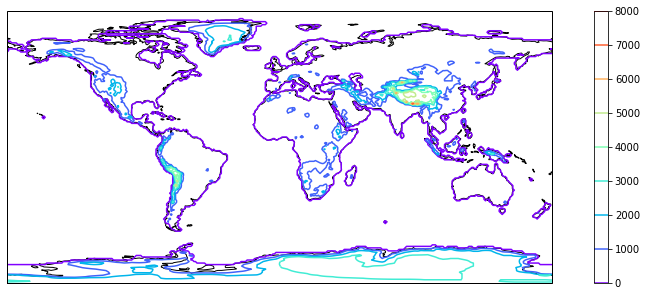

In [6]:
#Make the longitude coordinate cyclic (continuous at the booundary, connecting 0 deg to 360 deg)
sst, lons = add_cyclic_point(newlevs, coord=xlon)

plt.clf(); # clear the figure
plt.figure(figsize=(15, 5));
# Plot the figure on the left (1,2,1)
ax1 = plt.subplot(projection=ccrs.PlateCarree());
#plt.contourf(lons, ylat, sst, cmap='rainbow', transform=ccrs.PlateCarree())

plt.contour(lons, ylat, sst,cmap = "rainbow", transform=ccrs.PlateCarree())
plt.colorbar()

ax1.coastlines()

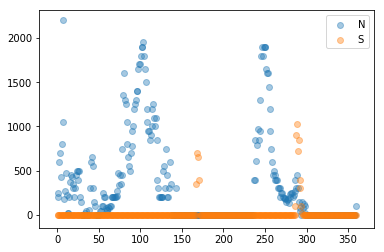

In [7]:
# look at one place to see if it works?
time1 = [i for i in range(len(ylat)) 
         if ylat[i] > 44.0 and ylat[i] < 46.0]
time2 = [i for i in range(len(ylat)) 
         if ylat[i] < -44.0 and ylat[i] > -46.0]

four5N = np.average([newlevs[time1[0]],newlevs[time1[1]]], axis = 0)
four5S = np.average([newlevs[time2[0]],newlevs[time2[1]]], axis = 0)

plt.clf()
plt.scatter(xlon, four5N, label = "N", alpha = 0.4)
plt.scatter(xlon, four5S, label = "S", alpha = 0.4)
plt.legend()
plt.show()

In [8]:
#see what they look like with fft?
Nfft = fft(four5N)
Sfft = fft(four5S)

#get phases
N_roots = np.array([root_find(entry) for entry in Nfft])
S_roots = np.array([root_find(entry) for entry in Sfft])

N_phase = N_roots[:,1] % (2*np.pi)
S_phase = S_roots[:,1] % (2*np.pi)

/home/clairev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


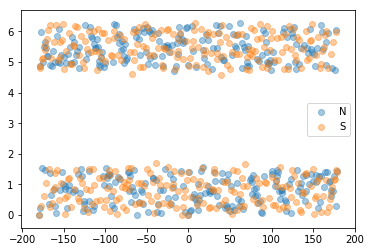

In [9]:
# get wavenumber
zonal_spacing2 = 1/fftfreq(360, 1)
zonal_spacing2 = 360 / zonal_spacing2
zonal_spacing2[0] = 0


# plot it
plt.clf()
plt.scatter(zonal_spacing2, N_phase, label = "N", alpha = 0.4)
plt.scatter(zonal_spacing2, S_phase, label = "S", alpha = 0.4)
plt.legend()
plt.show()

In [10]:
# look at another place (choose one before with longitude)
# get sample dataset
filepath = '/home/clairev/1979-2016-300hPa-45.0S-z.nc' # Location of the file
fileobj = Dataset(filepath, mode='r')

# Check what's in there
fileobj

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): longitude(240), time(55520)
    variables(dimensions): float32 z(time,longitude)
    groups: 

In [11]:
# get the other datasets too

# get already detrended dataset
data_store = pd.HDFStore('new_detrend_45.0S.h5')

# Retrieve data using key
untrend_df = data_store['untrend_geopot']
data_store.close()

# get already detrended dataset
data_store2 = pd.HDFStore('new_detrend_45.0N.h5')

# Retrieve data using key
untrend_df2 = data_store2['untrend_geopot']
data_store.close()

In [12]:
#create time array
time_list = []
for i in range(0,55520):
    time_list.append(i*6)
tunit = "hours since 1979-01-01T00:00:00Z"
tarray = num2date(time_list,units = tunit,calendar = 'gregorian')
print(tarray)

[real_datetime(1979, 1, 1, 0, 0) real_datetime(1979, 1, 1, 6, 0)
 real_datetime(1979, 1, 1, 12, 0) ... real_datetime(2016, 12, 31, 6, 0)
 real_datetime(2016, 12, 31, 12, 0) real_datetime(2016, 12, 31, 18, 0)]


In [13]:
#get 1995
indexing = []
for k in range(len(tarray)):
    if tarray[k].year == 2000:
        indexing.append(k)
        
ind_min = np.min(indexing)
ind_max = np.max(indexing)

In [14]:
if run_fresh == True:
    # apply fft
    oned_fft = untrend_df.groupby(["time"])["adj_z"].apply(fft)
    fft_arr = np.array(oned_fft)

    #solve for amplitudes and phase
    roots = [[root_find(lon) for lon in day] for day in fft_arr]
    np.save("roots_01.npy", roots)
    
    #do again
    oned_fft = untrend_df2.groupby(["time"])["adj_z"].apply(fft)
    fft_arr = np.array(oned_fft)

    #solve for amplitudes and phase
    roots2 = [[root_find(lon) for lon in day] for day in fft_arr]
    np.save("roots_02.npy", roots2)

if run_fresh == False:
    roots = np.load("roots_01.npy")
    roots2 = np.load("roots_02.npy")

In [25]:
# get wavenumber
zonal_spacing = 1/fftfreq(240, 1.5)
zonal_spacing = 360 / zonal_spacing
zonal_spacing[0] = 0

/home/clairev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [26]:
# separate phases and amps
phases = roots[:,:,1]
mean_phase = circmean(phases % (2 * np.pi), axis = 0)
#phases = phases % (2 * np.pi)
amps = roots[:,:,0]

In [27]:
# separate phases and amps
phases2 = roots2[:,:,1]
mean_phase2 = circmean(phases2 % (2 * np.pi), axis = 0)
amps2 = roots2[:,:,0]

In [28]:
i = 0
for k in range(240):
    if zonal_spacing[k] > 0 and amps[8][k] < 0:
        #print("ugh")
        i = i + 1

In [29]:
new_amps = []
new_phases = []

for days in range(len(amps)):
    day_list_a = []
    day_list_p = []
    
    for k in range(240):
        if zonal_spacing[k]*amps[days][k] < 0:
            newa = -1 * amps[days][k]
            newp = -1 * phases[days][k]
        else:
            newa = amps[days][k]
            newp = phases[days][k]
        
        day_list_a.append(newa)
        day_list_p.append(newp)
            
    new_amps.append(np.array(day_list_a))
    new_phases.append(np.array(day_list_p))
    
new_amps = np.array(new_amps)
new_phases = np.array(new_phases)

In [30]:
new_phases = new_phases % (2 * np.pi)
new_mean_phase = circmean(new_phases, axis = 0)

In [ ]:
new_amps2 = []
new_phases2 = []

for days in range(len(amps)):
    day_list_a = []
    day_list_p = []
    
    for k in range(240):
        if zonal_spacing[k]*amps2[days][k] < 0:
            newa = -1 * amps2[days][k]
            newp = -1 * phases2[days][k]
        else:
            newa = amps2[days][k]
            newp = phases2[days][k]
        
        day_list_a.append(newa)
        day_list_p.append(newp)
            
    new_amps2.append(np.array(day_list_a))
    new_phases2.append(np.array(day_list_p))
    
new_amps2 = np.array(new_amps2)
new_phases2 = np.array(new_phases2)

new_phases2 = new_phases2 % (2 * np.pi)
new_mean_phase2 = circmean(new_phases2, axis = 0)

In [ ]:
#mod phases and get standard deviation
phases = phases %(2 *np.pi)
phases2 = phases2 %(2 *np.pi)

stds = circvar(phases, axis = 0)
stds2 = circvar(phases2, axis = 0)

In [ ]:
k = 0
plt.clf()
plt.scatter(zonal_spacing, new_mean_phase, 
              label = "40.5 S", alpha = 0.4)
#plt.hlines(np.pi, xmin = -1, xmax = 360, label = "pi")
plt.legend()


plt.show()

In [ ]:
[i for i in range(len(zonal_spacing)) if zonal_spacing[i] >= 0 and zonal_spacing[i] < 6]

In [ ]:
k = 0
plt.clf()
plt.scatter(zonal_spacing, new_mean_phase2, 
              label = "40.5 N", alpha = 0.4)
#plt.hlines(np.pi, xmin = -1, xmax = 360, label = "pi")
plt.legend()
plt.xlim(left = 0.01)

plt.show()

In [ ]:
#freeze up to wavenumber = 5?

In [ ]:
k = 0
plt.clf()
plt.scatter(zonal_spacing, stds, 
              label = "std", alpha = 0.4)
#plt.hlines(np.pi, xmin = -1, xmax = 360, label = "pi")
#plt.legend()
plt.xlim(left = 0.05)

plt.show()

In [ ]:
k = 0
plt.clf()
plt.scatter(zonal_spacing, stds2, 
              label = "std", alpha = 0.4)
#plt.hlines(np.pi, xmin = -1, xmax = 360, label = "pi")
#plt.legend()
plt.xlim(left = 0.05)

plt.show()

lock phase with wavenumber <= 5 (absolute value), using std dev to give (a little) standard variation then run sim

In [37]:
#get phases
new_roots_1 = np.load("roots_new_01.npy")
new_roots_2 = np.load("roots_new_02.npy")

In [38]:
phases_1 = [[[[entry[1] for entry in subrow] 
              for subrow in lon] 
             for lon in season] 
            for season in new_roots_1]
phases_2 = [[[[entry[1] for entry in subrow] 
              for subrow in lon] 
             for lon in season] 
            for season in new_roots_2]

amps_1 = [[[[entry[0] for entry in subrow] 
              for subrow in lon] 
             for lon in season] 
            for season in new_roots_1]
amps_2 = [[[[entry[0] for entry in subrow] 
              for subrow in lon] 
             for lon in season] 
            for season in new_roots_2]

In [39]:
#mod phases
phases_mod_1 = [[[[entry[1]% (2 * np.pi) for entry in subrow] 
              for subrow in lon] 
             for lon in season] 
            for season in new_roots_1]
phases_mod_2 = [[[[entry[1]% (2 * np.pi) for entry in subrow] 
              for subrow in lon] 
             for lon in season] 
            for season in new_roots_2]

In [40]:
def padded(to_pad, max_len):
    length = len(to_pad)
    zeros = max_len - length
    to_pad = list(to_pad)
    for i in range(zeros):
        to_pad.append(0)
    return to_pad

In [41]:
len_list = [[len(entry[0]) for entry in season] for season in new_roots_1]
max_len = [max(entry) for entry in len_list]
total_max = max(max_len)

In [42]:
padded_lists = [[[padded(row, total_max) for row in entry] 
                     for entry in phases_1[i]] for i in range(4)]
padded_lists2 = [[[padded(row, total_max) for row in entry] 
                     for entry in phases_2[i]] for i in range(4)]

pad_amps1 = [[[padded(row, total_max) for row in entry] 
                     for entry in amps_1[i]] for i in range(4)]
pad_amps2 = [[[padded(row, total_max) for row in entry] 
                     for entry in amps_2[i]] for i in range(4)]

pad_phase1 = [[[padded(row, total_max) for row in entry] 
                     for entry in phases_1[i]] for i in range(4)]
pad_phase2 = [[[padded(row, total_max) for row in entry] 
                     for entry in phases_2[i]] for i in range(4)]

In [43]:
# get mean and variance
mean_phase_1 = [circmean(np.array(season), axis = 0) for season in padded_lists]
mean_phase_2 = [circmean(np.array(season), axis = 0) for season in padded_lists2]

var_phase_1 = [circvar(np.array(season), axis = 0) for season in padded_lists]
var_phase_2 = [circvar(np.array(season), axis = 0) for season in padded_lists2]

In [44]:
# do switchy thing
def ret_sign(x):
    if x < 0:
        return -1.0
    else:
        return 1.0

    
    
signed_amps_1 = [[[[ret_sign(entry) for entry in subrow] 
              for subrow in lon] 
             for lon in season] 
            for season in pad_amps1]
signed_amps_2 = [[[[ret_sign(entry) for entry in subrow] 
              for subrow in lon] 
             for lon in season] 
            for season in pad_amps2]

In [45]:
new_amps1 = [[[[signed_amps_1[season][lon][subrow][entry] * pad_amps1[season][lon][subrow][entry] 
                for entry in range(len(pad_amps1[season][lon][subrow]))] 
              for subrow in range(len(pad_amps1[season][lon]))] 
             for lon in range(len(pad_amps1[season]))] 
            for season in range(len(pad_amps1))]
new_phase1 = [[[[signed_amps_1[season][lon][subrow][entry] * pad_phase1[season][lon][subrow][entry] 
                for entry in range(len(pad_amps1[season][lon][subrow]))] 
              for subrow in range(len(pad_amps1[season][lon]))] 
             for lon in range(len(pad_amps1[season]))] 
            for season in range(len(pad_amps1))]

new_amps2 = [[[[signed_amps_2[season][lon][subrow][entry] * pad_amps2[season][lon][subrow][entry] 
                for entry in range(len(pad_amps1[season][lon][subrow]))] 
              for subrow in range(len(pad_amps1[season][lon]))] 
             for lon in range(len(pad_amps1[season]))] 
            for season in range(len(pad_amps1))]
new_phase2 = [[[[signed_amps_2[season][lon][subrow][entry] * pad_phase2[season][lon][subrow][entry] 
                for entry in range(len(pad_amps1[season][lon][subrow]))] 
              for subrow in range(len(pad_amps1[season][lon]))] 
             for lon in range(len(pad_amps1[season]))] 
            for season in range(len(pad_amps1))]

In [46]:
#mod phases by 2*pi
new_phase1 = [[[[entry%(2*np.pi) for entry in subrow] 
              for subrow in lon] 
             for lon in season] 
            for season in new_phase1]
new_phase2 = [[[[entry%(2*np.pi) for entry in subrow] 
              for subrow in lon] 
             for lon in season] 
            for season in new_phase2]

In [47]:
# get mean and variance for new data
new_mean_phase_1 = [circmean(np.array(season), axis = 0) for season in new_phase1]
new_mean_phase_2 = [circmean(np.array(season), axis = 0) for season in new_phase2]

new_var_phase_1 = [circvar(np.array(season), axis = 0) for season in new_phase1]
new_var_phase_2 = [circvar(np.array(season), axis = 0) for season in new_phase2]

In [48]:
seasonlabs = ["Winter", "Spring", "Summer", "Fall"]

<Figure size 432x288 with 0 Axes>

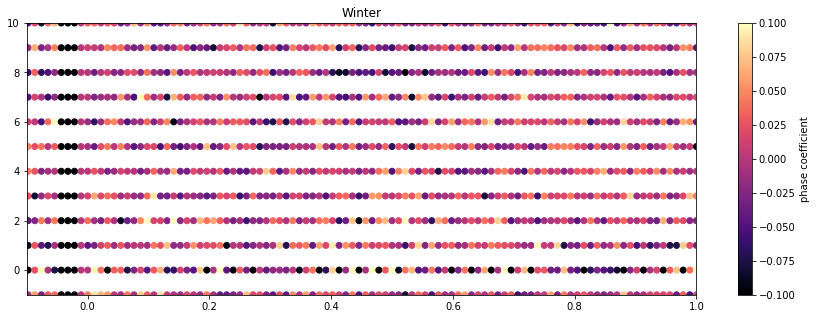

<Figure size 432x288 with 0 Axes>

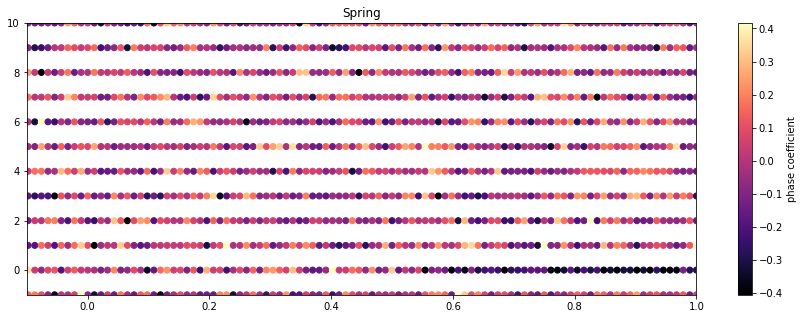

<Figure size 432x288 with 0 Axes>

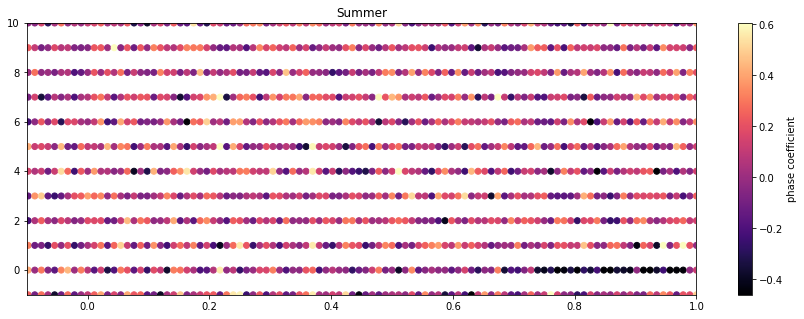

<Figure size 432x288 with 0 Axes>

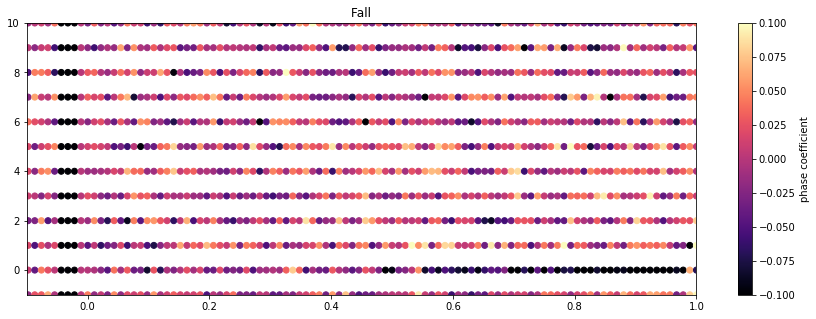

In [49]:
for k in range(4):
    sample_data = mean_phase_1[k]
    plt.clf()
    plt.figure(figsize=(15, 5));
    frequencies = fftfreq(len(sample_data[0]), 0.25)

    for i in range(len(frequencies)):
        plt.scatter(x = [frequencies[i]]*240, y = zonal_spacing, 
                c = np.array(sample_data)[:,i], cmap = "magma")

    plt.colorbar(label = "phase coefficient")
    plt.title(seasonlabs[k])
    plt.xlim((-0.1,1))
    plt.ylim((-1,10))
    plt.show()

<Figure size 432x288 with 0 Axes>

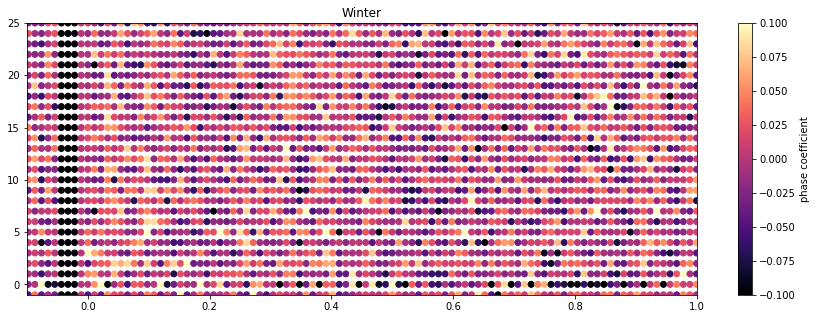

<Figure size 432x288 with 0 Axes>

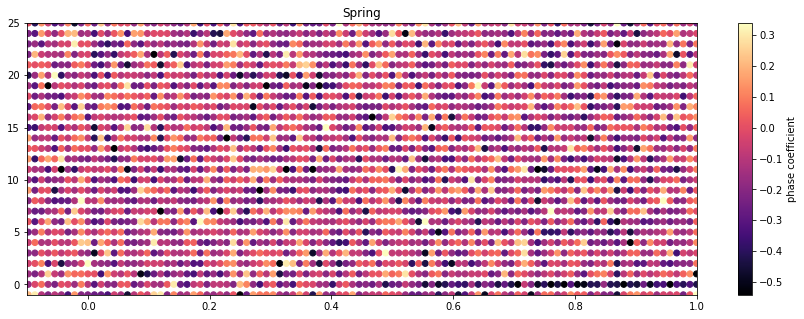

<Figure size 432x288 with 0 Axes>

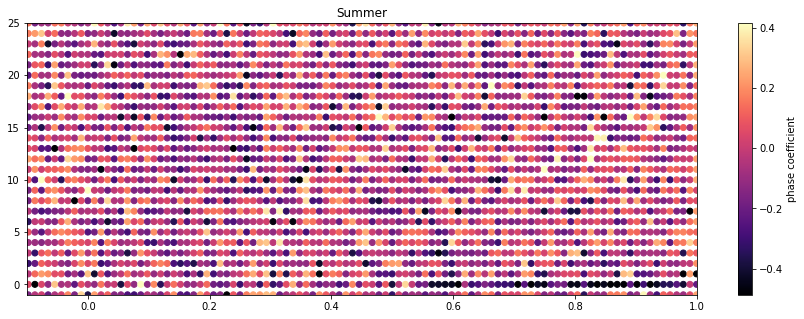

<Figure size 432x288 with 0 Axes>

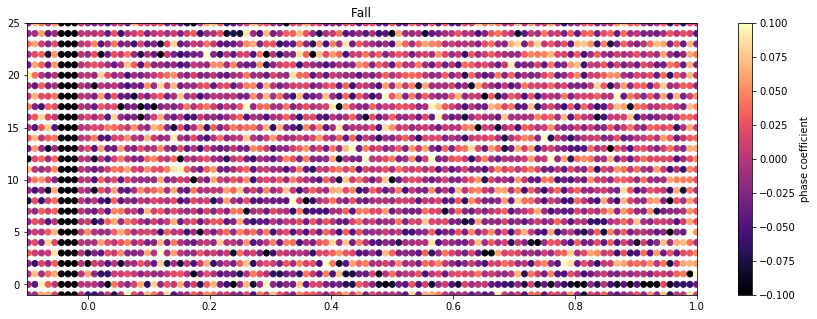

In [50]:
for k in range(4):
    sample_data = mean_phase_2[k]
    plt.clf()
    plt.figure(figsize=(15, 5));
    frequencies = fftfreq(len(sample_data[0]), 0.25)

    for i in range(len(frequencies)):
        plt.scatter(x = [frequencies[i]]*240, y = zonal_spacing, 
                c = np.array(sample_data)[:,i], cmap = "magma")

    plt.colorbar(label = "phase coefficient")
    plt.title(seasonlabs[k])
    plt.xlim((-0.1,1))
    plt.ylim((-1,25))
    plt.show()

<Figure size 432x288 with 0 Axes>

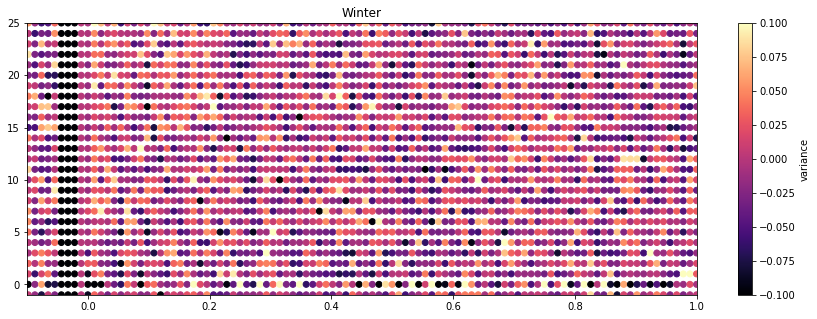

<Figure size 432x288 with 0 Axes>

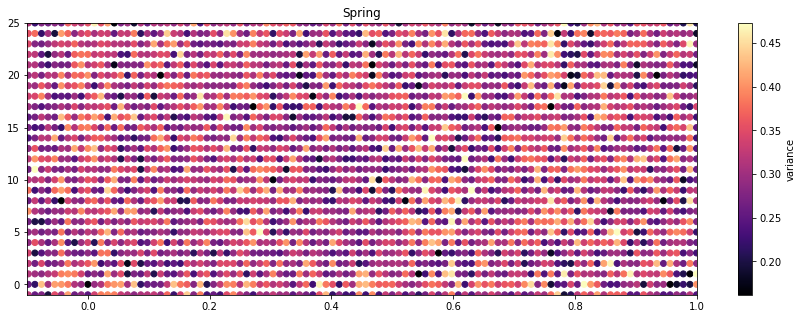

<Figure size 432x288 with 0 Axes>

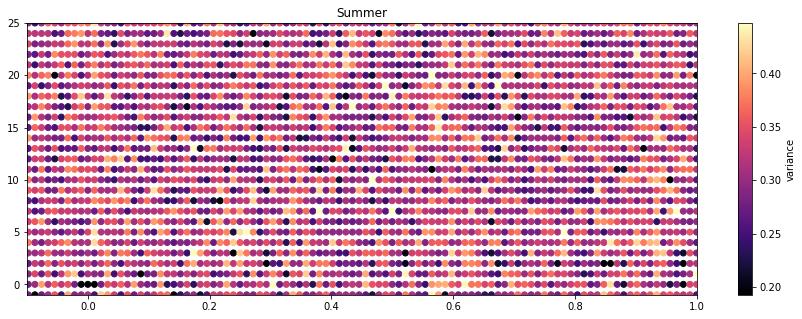

<Figure size 432x288 with 0 Axes>

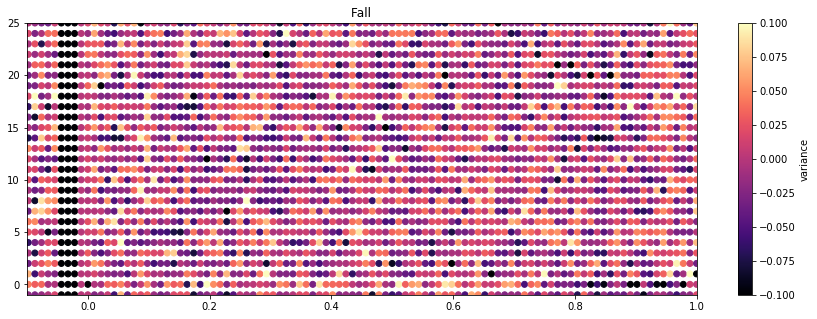

In [51]:
for k in range(4):
    sample_data = var_phase_1[k]
    plt.clf()
    plt.figure(figsize=(15, 5));
    frequencies = fftfreq(len(sample_data[0]), 0.25)

    for i in range(len(frequencies)):
        plt.scatter(x = [frequencies[i]]*240, y = zonal_spacing, 
                c = np.array(sample_data)[:,i], cmap = "magma")

    plt.colorbar(label = "variance")
    plt.title(seasonlabs[k])
    plt.xlim((-0.1,1))
    plt.ylim((-1,25))
    plt.show()

<Figure size 432x288 with 0 Axes>

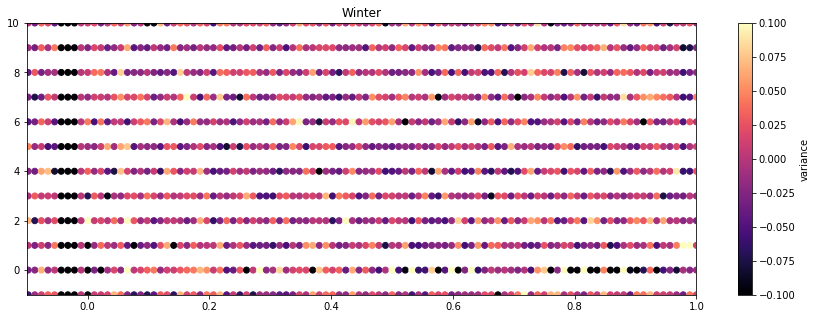

<Figure size 432x288 with 0 Axes>

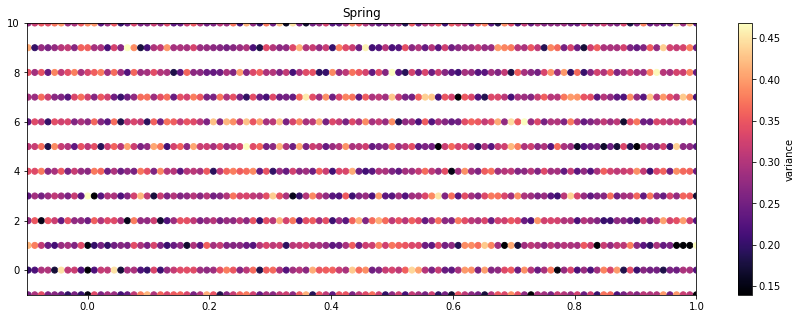

<Figure size 432x288 with 0 Axes>

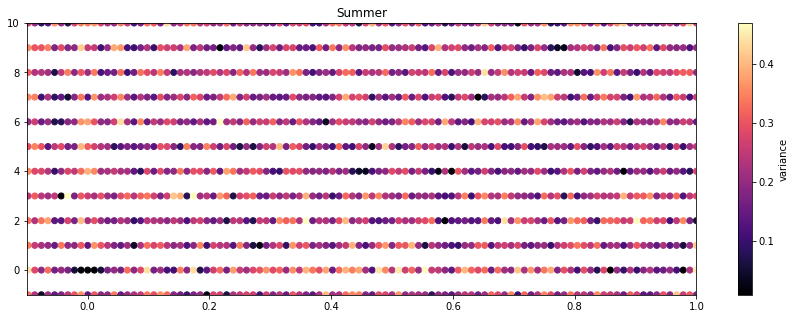

<Figure size 432x288 with 0 Axes>

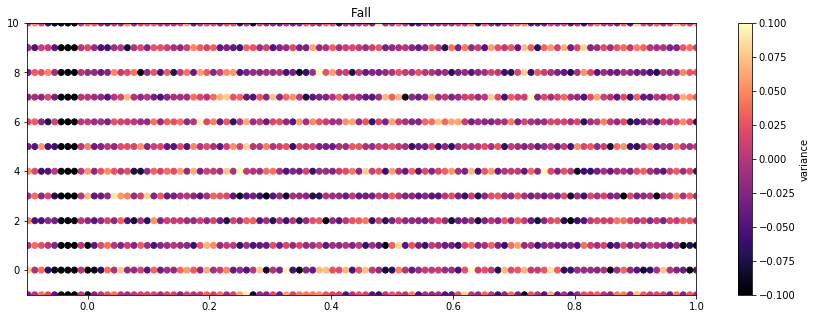

In [52]:
for k in range(4):
    sample_data = var_phase_2[k]
    plt.clf()
    plt.figure(figsize=(15, 5));
    frequencies = fftfreq(len(sample_data[0]), 0.25)

    for i in range(len(frequencies)):
        plt.scatter(x = [frequencies[i]]*240, y = zonal_spacing, 
                c = np.array(sample_data)[:,i], cmap = "magma")

    plt.colorbar(label = "variance")
    plt.title(seasonlabs[k])
    plt.xlim((-0.1,1))
    plt.ylim((-1,10))
    plt.show()

In [53]:
flat1 = [seasoned for season in new_mean_phase_1 for seasoned in season]
len(flat1)

960

In [54]:
#see if there is anything over all seasons
# get mean and variance for new data

new_mean_phase_21 = circmean(np.array(new_mean_phase_1), axis = 0)
new_mean_phase_22 = circmean(np.array(new_mean_phase_2), axis = 0)

all_mean_phase1 = circmean(new_mean_phase_21, axis = 1)
all_mean_phase2 = circmean(new_mean_phase_22, axis = 1)


<Figure size 432x288 with 0 Axes>

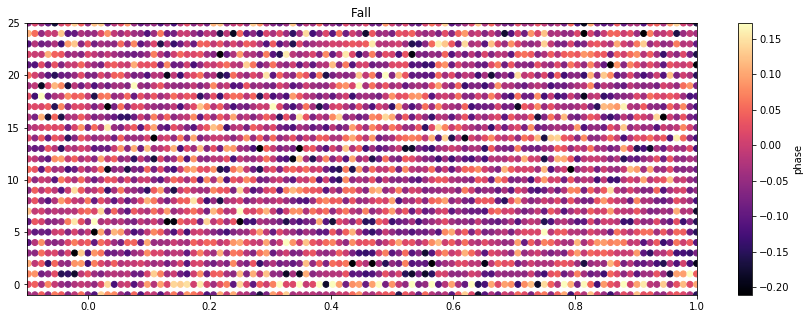

In [55]:
sample_data = new_mean_phase_21
plt.clf()
plt.figure(figsize=(15, 5));
frequencies = fftfreq(len(sample_data[0]), 0.25)

for i in range(len(frequencies)):
    plt.scatter(x = [frequencies[i]]*240, y = zonal_spacing, 
            c = np.array(sample_data)[:,i], cmap = "magma")

plt.colorbar(label = "phase")
plt.title(seasonlabs[k])
plt.xlim((-0.1,1))
plt.ylim((-1,25))
plt.show()

<Figure size 432x288 with 0 Axes>

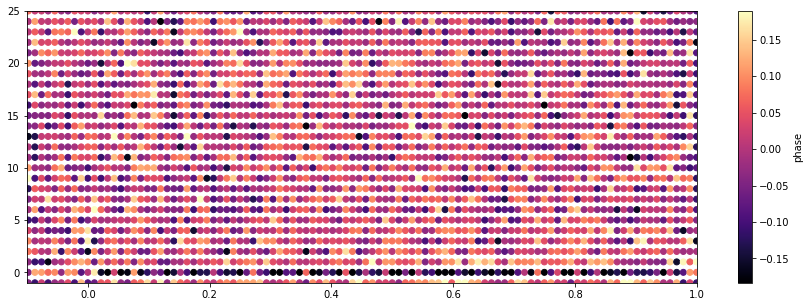

In [56]:
sample_data = new_mean_phase_22
plt.clf()
plt.figure(figsize=(15, 5));
frequencies = fftfreq(len(sample_data[0]), 0.25)

for i in range(len(frequencies)):
    plt.scatter(x = [frequencies[i]]*240, y = zonal_spacing, 
            c = np.array(sample_data)[:,i], cmap = "magma")

plt.colorbar(label = "phase")
plt.xlim((-0.1,1))
plt.ylim((-1,25))
plt.show()

<Figure size 432x288 with 0 Axes>

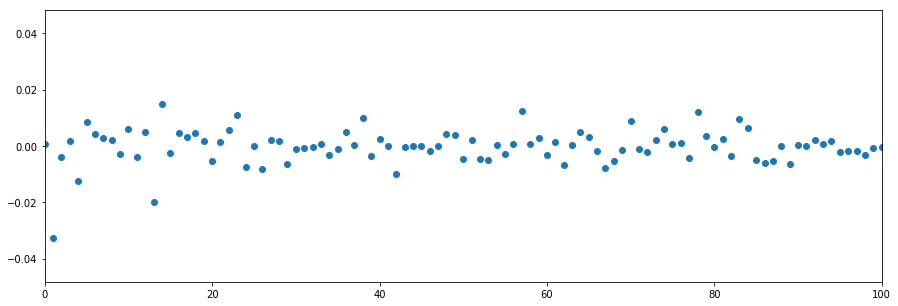

In [57]:
plt.clf()
plt.figure(figsize=(15, 5));
plt.scatter(x = zonal_spacing, y = all_mean_phase1)
plt.xlim((0,100))
plt.show()

<Figure size 432x288 with 0 Axes>

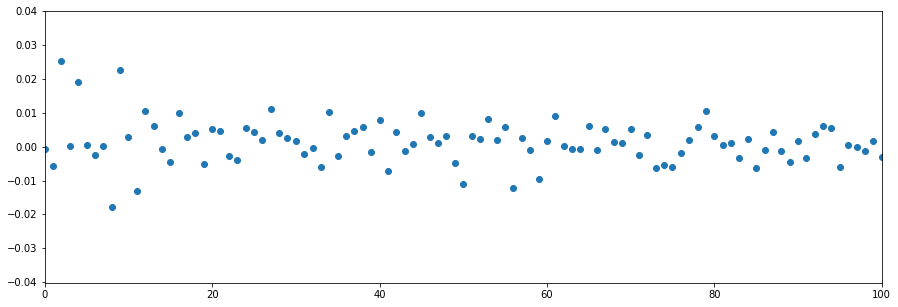

In [58]:
plt.clf()
plt.figure(figsize=(15, 5));
plt.scatter(x = zonal_spacing, y = all_mean_phase2)
plt.xlim((0,100))
plt.show()